__Author: Peter Kicsiny__

Tested with Xsuite versions:
- xobjects: 0.4.5 
- xtrack: 0.70.3 
- xfields: 0.21.3 
- xpart: 0.19.3

In [14]:
import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 32
matplotlib.rcParams['figure.subplot.left'] = 0.18
matplotlib.rcParams['figure.subplot.bottom'] = 0.16
matplotlib.rcParams['figure.subplot.right'] = 0.92
matplotlib.rcParams['figure.subplot.top'] = 0.9
matplotlib.rcParams['figure.figsize'] = (12,8)

print(xo.__version__, xt.__version__, xf.__version__, xp.__version__)

0.4.5 0.70.3 0.21.3 0.19.3


This example uses the FCC-ee ttbar parameters. These parameters come from: https://indico.cern.ch/event/1202105/contributions/5408583/attachments/2659051/4608141/FCCWeek_Optics_Oide_230606.pdf

In [15]:
bunch_intensity     = 1.55e11  # [1]
energy              = 182.5  # [GeV]
p0c                 = energy*1e9  # [eV]
mass0               = 511000  # [eV]
phi                 = 15e-3  # [rad] half xing
u_sr                = 10.42  # [GeV]
qx                  = 0.537  # [1] superperiod tune
qy                  = 0.546  # [1]
qs                  = 0.02275  # [1]
physemit_x          = 1.59e-09  # [m]
physemit_y          = 9e-13  # [m]
beta_x              = 1  # [m]
beta_y              = 1.6e-3  # [m]
sigma_x             = np.sqrt(physemit_x*beta_x)  # [m]
sigma_px            = np.sqrt(physemit_x/beta_x)  # [1]
sigma_y             = np.sqrt(physemit_y*beta_y)  # [m]
sigma_py            = np.sqrt(physemit_y/beta_y)  # [1]
sigma_z             = 1.81e-3  # [m] sr
sigma_delta         = 16e-4  # [1]
beta_s              = sigma_z/sigma_delta  # [m]
physemit_s          = sigma_z*sigma_delta  # [m]
n_ip                = 4  # [1]

n_turns = 500

Define the number of macroparticles to track. A macroparticle is different from a real particle in the sense that its contribution to the collective forces such as the beam-beam force is scaled by a weight factor, such that the number of macroparticles times the weight equals the bunch intensity. Otherwise a macroparticle has the same charge and mass as a real particle. This is so that we do not need to track $10^{11}$ particles but only between $10^3$-$10^6$. The number of macroparticles does not need to be large here as their motion is intependent during tracking without beam-beam.

In [16]:
n_macroparticles_b1 = int(1e3)

The context defines the platform. The platform can be thought of as the execution environment, such as a CPU with a given amount of threads or a GPU using a given programming interface such as CUDA or OpenCL.

In [17]:
context = xo.ContextCpu(omp_num_threads=8)

We define an electron beam with 1000 macroparticles with initial distributions characterized by the variables `*_init`. We also define the equilibrium parameters denoted by the variables `*_eq`. All of these can be defined arbitrarily but here we use the nominal equilibrium numbers from the reference.

In [18]:
# initial beam sizes
(sigma_x_init, sigma_y_init, sigma_z_init,
 sigma_px_init, sigma_py_init, sigma_delta_init,
 physemit_x_init, physemit_y_init, physemit_s_init) = (     2*sigma_x,      3*sigma_y,      4*sigma_z, 
                                                           2*sigma_px,     3*sigma_py,  4*sigma_delta, 
                                                       2*2*physemit_x, 3*3*physemit_y, 4*4*physemit_s
                                                      )
# synrad equilibrium beam sizes
(sigma_x_eq, sigma_y_eq, sigma_z_eq, 
 sigma_px_eq, sigma_py_eq, sigma_delta_eq, 
 physemit_x_eq, physemit_y_eq, physemit_s_eq) = (   sigma_x,    sigma_y,     sigma_z,
                                                   sigma_px,   sigma_py, sigma_delta,
                                                 physemit_x, physemit_y,  physemit_s
                                                )

# for reproducibility fix the random seed
np.random.seed(42)

# this is an electron beam
particles_b1 = xp.Particles(
            _context = context, 
            q0        = -1,
            p0c       = p0c,
            mass0     = mass0,
            x         = sigma_x_init        *np.random.randn(n_macroparticles_b1),
            y         = sigma_y_init        *np.random.randn(n_macroparticles_b1),
            zeta      = sigma_z_init        *np.random.randn(n_macroparticles_b1),
            px        = sigma_px_init       *np.random.randn(n_macroparticles_b1),
            py        = sigma_py_init       *np.random.randn(n_macroparticles_b1),
            delta     = sigma_delta_init    *np.random.randn(n_macroparticles_b1),
            weight=bunch_intensity/n_macroparticles_b1
)

# this is needed to init random number generator used for random gaussian noise in arc (see later)
particles_b1._init_random_number_generator()

{'Particles_initialize_rand_gen': <xobjects.context.Kernel object at 0x109b9ae90>}
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


Note here that the weight of the macroparticles is usually chosen uniformly such that their sum yields the total bunch intensity.

In [19]:
assert bunch_intensity == particles_b1.weight.sum()

Now let's define the accelerator as a linear transfer map, with effective synchrotron radiation. Effective synchrotron radiation means exponential damping + Gaussian random noise excitation applied to each particle. In a more realistic "quantum" synchrotron radiation model instead each particle undergoes random photon emission with energy drawn from a distribution function. The Xsuite `LineSegmentMap` object takes in the damping rates and random noise amplitudes of the RMS bunch size. This can be obtained by halving the damping rate and noise amplitude of the emittance.

In [20]:
emit_damping_rate_s  = 2 * u_sr / energy / n_ip
emit_damping_rate_x = emit_damping_rate_s/2
emit_damping_rate_y = emit_damping_rate_s/2
sigma_damping_rate_s =  emit_damping_rate_s / 2
sigma_damping_rate_x = sigma_damping_rate_s / 2
sigma_damping_rate_y = sigma_damping_rate_s / 2

The optical functions (alpha and beta) at the location of the crab sextupoles can be chosen somewhat arbitrarily. Here I chose `alpha_sext` to be 0 and `beta_y_sext` a large number and `beta_x_sext` a small number. In general as long as `beta_x_sext` is small, there is a freedom to choose `beta_y_sext`. Similarly, as long as `beta_y_sext` is large, there is a freedom to choose `beta_x_sext`. This information is inherited from D. Shatilov and it is arbitrary. The radiation is only set up in the middle arc segment. The crucial part is the setup of the phase advances in `qx` and `qy` such that it corresponds to the crab-waist scheme.

In [21]:
beta_x_sext_left  = 3
beta_y_sext_left  = 500
beta_x_sext_right = 3
beta_y_sext_right = 500

alpha_x_sext_left  = 0
alpha_y_sext_left  = 0
alpha_x_sext_right = 0
alpha_y_sext_right = 0

# from IP to right crab sextupole
el_arc_left_b1 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beta_x, beta_x_sext_left],
    bety = [beta_y, beta_y_sext_left],
    alfx = [0, alpha_x_sext_left],
    alfy = [0, alpha_y_sext_left],
    bets = beta_s,
)

el_arc_mid_b1 = xt.LineSegmentMap(_context=context,
    qx =  qx, 
    qy =  qy -.5 , # subtract .25*2 phase advance from small arcs
    qs =  qs,
    betx = [beta_x_sext_left, beta_x_sext_right],
    bety = [beta_y_sext_left, beta_y_sext_right],
    alfx = [alpha_x_sext_left, alpha_x_sext_right],
    alfy = [alpha_y_sext_left, alpha_y_sext_right],
    bets = beta_s,
    damping_rate_x     = sigma_damping_rate_x,
    damping_rate_px    = sigma_damping_rate_x,
    damping_rate_y     = sigma_damping_rate_y,
    damping_rate_py    = sigma_damping_rate_y,
    damping_rate_zeta  = sigma_damping_rate_s,
    damping_rate_pzeta = sigma_damping_rate_s,
                                  
    # noise has to be normalized to beamsize at exit using beta at exit!
    gauss_noise_ampl_x     = np.sqrt(physemit_x_eq*beta_x_sext_right) * np.sqrt(emit_damping_rate_x),
    gauss_noise_ampl_px    = np.sqrt(physemit_x_eq/beta_x_sext_right) * np.sqrt(emit_damping_rate_x),
    gauss_noise_ampl_y     = np.sqrt(physemit_y_eq*beta_y_sext_right) * np.sqrt(emit_damping_rate_y),
    gauss_noise_ampl_py    = np.sqrt(physemit_y_eq/beta_y_sext_right) * np.sqrt(emit_damping_rate_y),
    gauss_noise_ampl_zeta  =     sigma_z_eq * np.sqrt(emit_damping_rate_s),
    gauss_noise_ampl_pzeta = sigma_delta_eq * np.sqrt(emit_damping_rate_s),
)

# from left crab sextupole to IP2
el_arc_right_b1 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beta_x_sext_right, beta_x],
    bety = [beta_y_sext_right, beta_y],
    alfx = [alpha_x_sext_right, 0],
    alfy = [alpha_y_sext_right, 0],
    bets = beta_s,
)

Here we will have 2 monitors: one at the IP and one outside crab-waist region.

In [22]:
monitor_coords_1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=n_turns, particle_id_range=(0,n_macroparticles_b1))
monitor_coords_2 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=n_turns, particle_id_range=(0,n_macroparticles_b1))

Next we build the accelerator model which means that the underlying C code corresponding to the elements in the accelerator line gets compiled.

In [23]:
line = xt.Line(elements = [
                          monitor_coords_1,
                          el_arc_left_b1,
                          el_arc_mid_b1,
                          monitor_coords_2,
                          el_arc_right_b1,
])
line.build_tracker(_context=context)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


Track the 1000 particles for 500 turns with effective synchrotron radiation. As a result of this the bunch size should damp to the equilibrium with the damping time defined above.

In [24]:
line.track(particles_b1, num_turns=n_turns)

Now we retrieve the data from the monitor, calculate the emittances and RMS beam sizes and plot them against the number of tracking iterations.

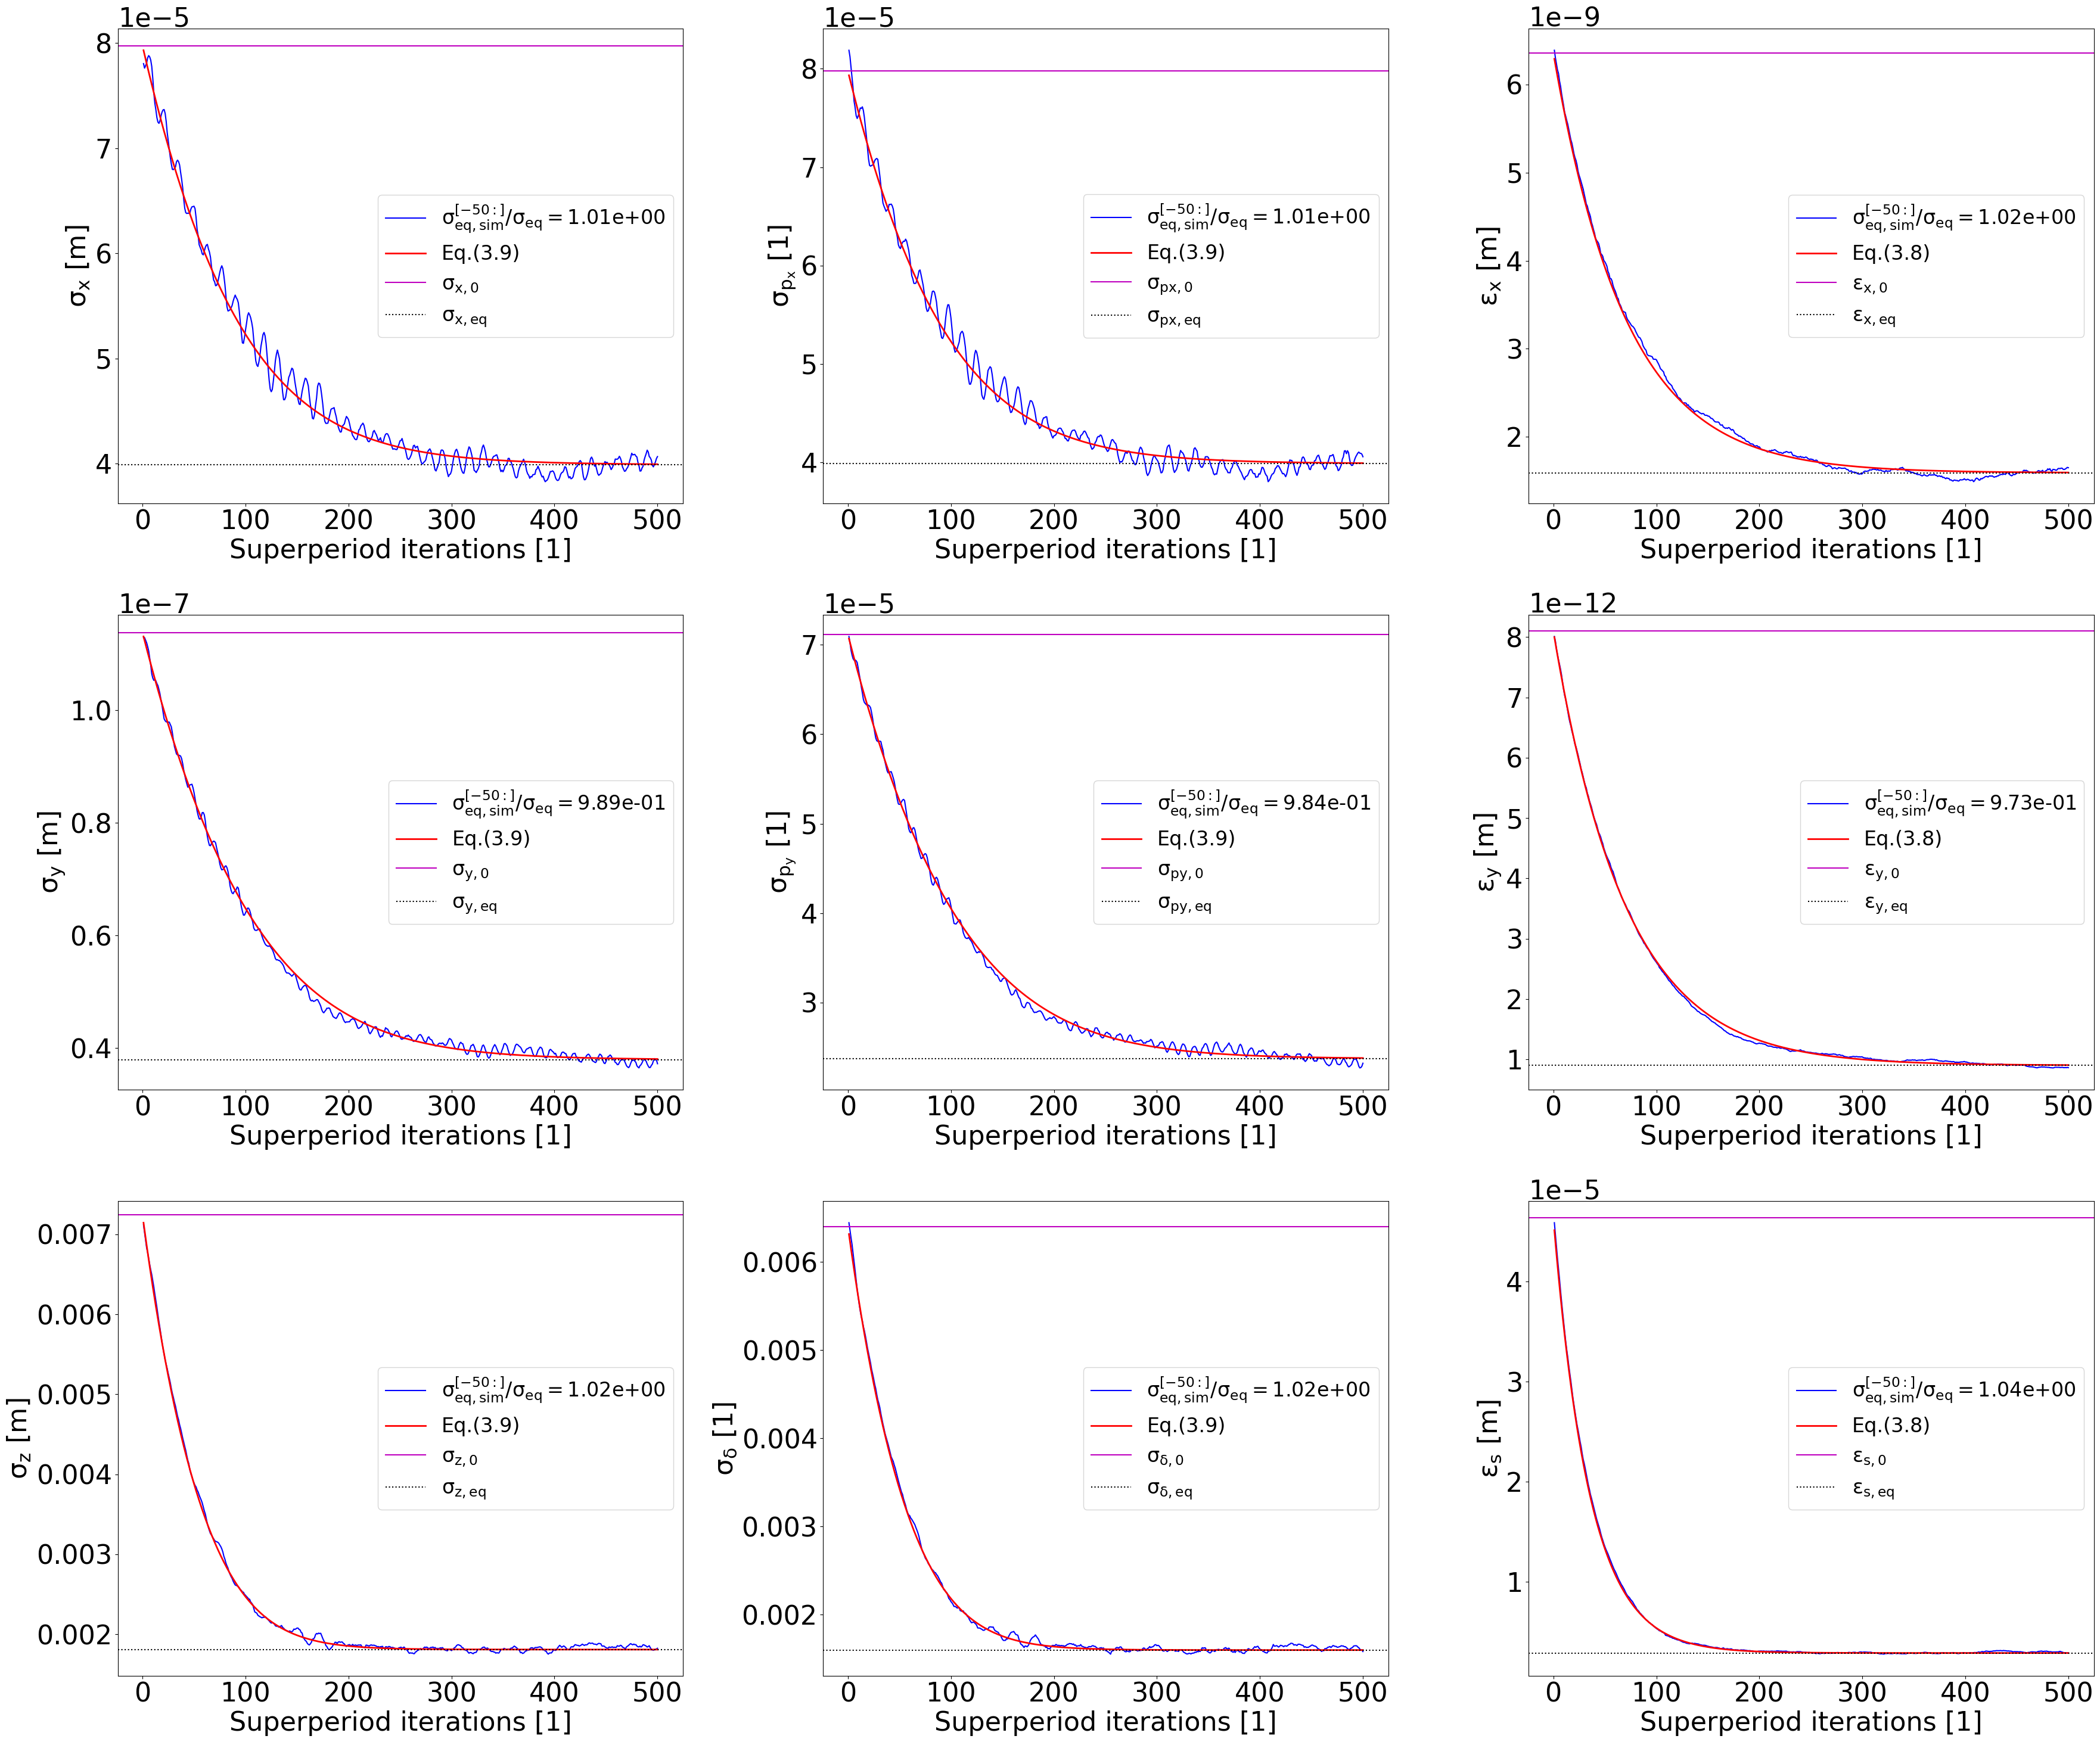

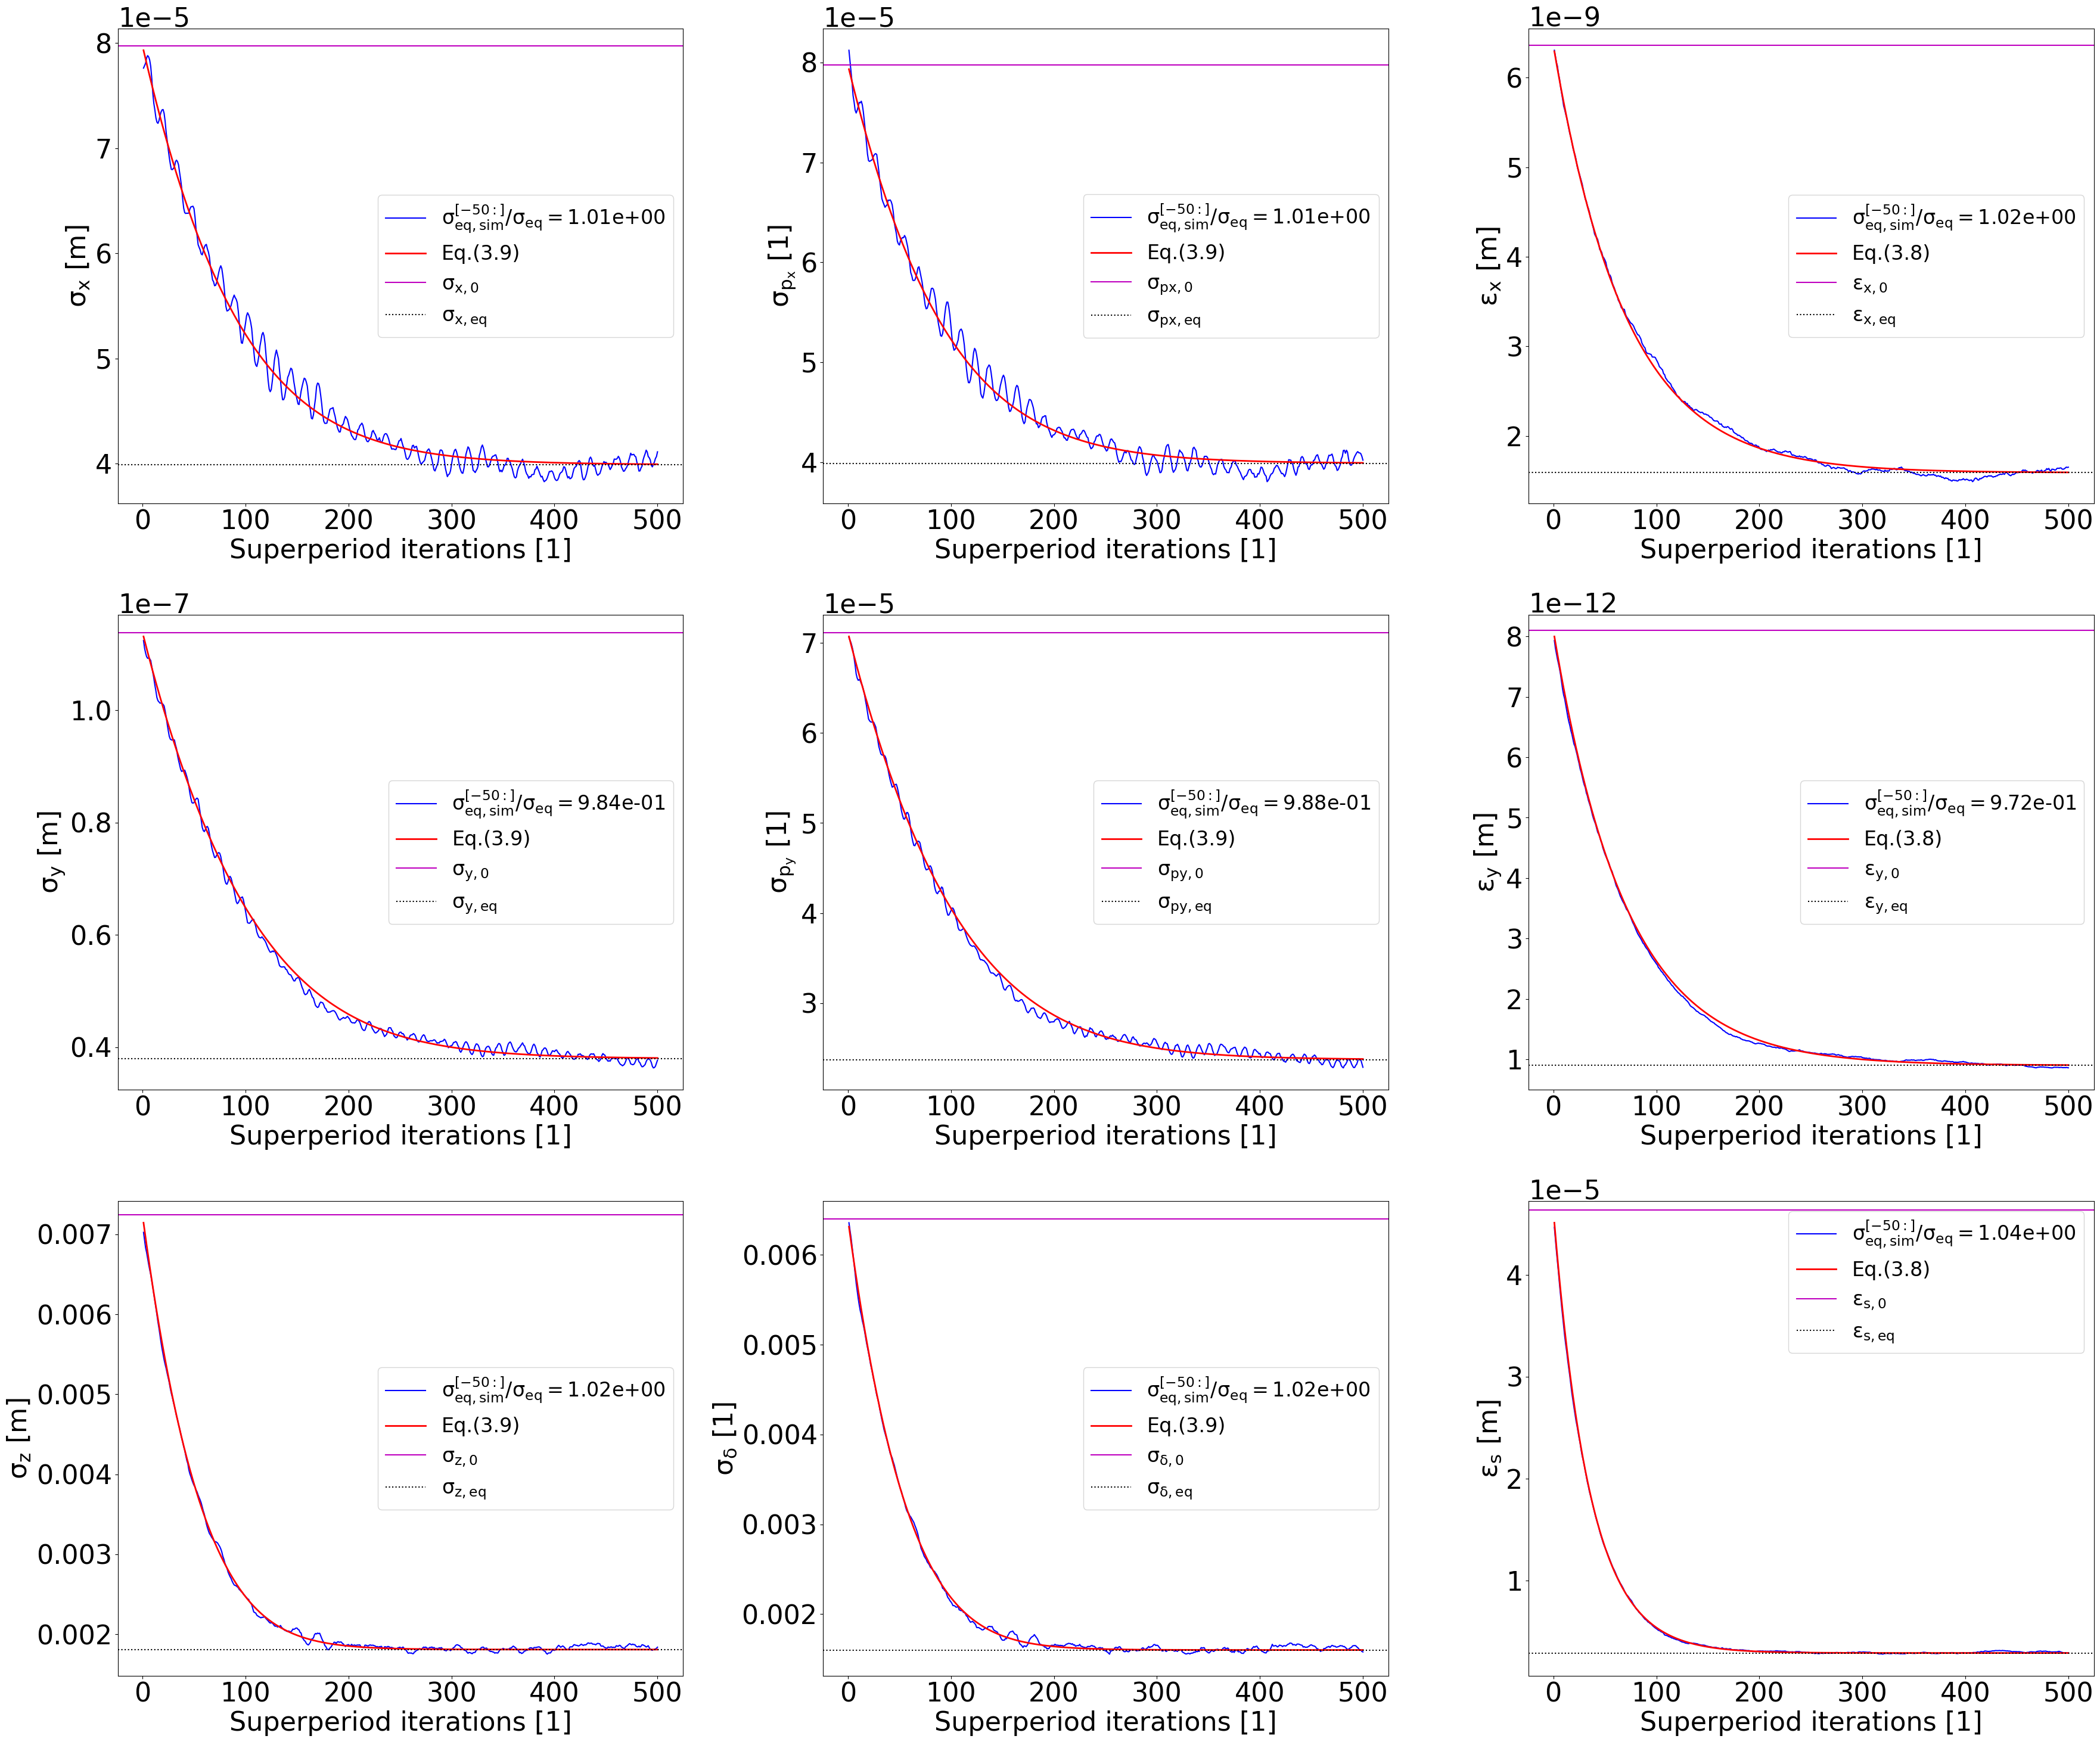

In [25]:
monitors = [monitor_coords_1, monitor_coords_2]
beta_x_at_mon = [beta_x, beta_x_sext_right]
beta_y_at_mon = [beta_y, beta_y_sext_right]

for monitor_coords, beta_x_mon, beta_y_mon in zip(monitors, beta_x_at_mon, beta_y_at_mon):
    coords_dict = monitor_coords.to_dict()["data"]
    
    x_arr_     = np.reshape(coords_dict[    "x"], (n_macroparticles_b1, n_turns))
    y_arr_     = np.reshape(coords_dict[    "y"], (n_macroparticles_b1, n_turns))
    z_arr     = np.reshape(coords_dict[ "zeta"], (n_macroparticles_b1, n_turns))
    px_arr_    = np.reshape(coords_dict[   "px"], (n_macroparticles_b1, n_turns))
    py_arr_    = np.reshape(coords_dict[   "py"], (n_macroparticles_b1, n_turns))
    delta_arr = np.reshape(coords_dict["delta"], (n_macroparticles_b1, n_turns))
    
    # scale back to IP betas, using transfer matrix (alpha=0 here)
    x_arr     =  x_arr_ *    np.sqrt(beta_x/beta_x_mon) # this is bc Qx=0
    y_arr     = py_arr_ *    np.sqrt(beta_y*beta_y_mon) # this is bc Qy=pi/2
    px_arr    = px_arr_ *    np.sqrt(beta_x_mon/beta_x) 
    py_arr    =  y_arr_ * -1/np.sqrt(beta_y_mon*beta_y)
            
    x_co_arr     = np.mean(x_arr    , axis=0)    
    y_co_arr     = np.mean(y_arr    , axis=0)    
    z_co_arr     = np.mean(z_arr    , axis=0)    
    px_co_arr    = np.mean(px_arr   , axis=0)   
    py_co_arr    = np.mean(py_arr   , axis=0)   
    delta_co_arr = np.mean(delta_arr, axis=0)
    
    x_std_arr     = np.std(x_arr    , axis=0)    
    y_std_arr     = np.std(y_arr    , axis=0)    
    z_std_arr     = np.std(z_arr    , axis=0)    
    px_std_arr    = np.std(px_arr   , axis=0)   
    py_std_arr    = np.std(py_arr   , axis=0)   
    delta_std_arr = np.std(delta_arr, axis=0)
    
    emits_dict = coords_dict
    
    emit_x_arr = np.sqrt(np.mean(( x_arr -  np.mean(x_arr, axis=0))**2, axis=0) *\
                         np.mean((px_arr - np.mean(px_arr, axis=0))**2, axis=0) -\
                         np.mean(( x_arr -  np.mean(x_arr, axis=0)) *\
                                 (px_arr - np.mean(px_arr, axis=0)), axis=0)**2)
        
    emit_y_arr = np.sqrt(np.mean(( y_arr -  np.mean(y_arr, axis=0))**2, axis=0) *\
                         np.mean((py_arr - np.mean(py_arr, axis=0))**2, axis=0) -\
                         np.mean(( y_arr -  np.mean(y_arr, axis=0)) *\
                                 (py_arr - np.mean(py_arr, axis=0)), axis=0)**2)
        
    emit_s_arr = np.sqrt(np.mean((    z_arr - np.mean(    z_arr, axis=0))**2, axis=0) *\
                         np.mean((delta_arr - np.mean(delta_arr, axis=0))**2, axis=0) -\
                         np.mean((    z_arr - np.mean(    z_arr, axis=0)) *\
                                 (delta_arr - np.mean(delta_arr, axis=0)), axis=0)**2)
    
    ##################
    # plot evolution #
    ##################
    
    # this is used to compute simulated equilibrium from last w coordinates in legend
    w = 50
    
    turns_arr = np.linspace(1, n_turns, int(n_turns))
    
    fig, ax = plt.subplots(3,3, figsize=(36,30))
    
    # x, y, z
    ax[0,0].plot(turns_arr, x_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(x_std_arr[-w:])/sigma_x_eq:.2e}")
    ax[1,0].plot(turns_arr, y_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(y_std_arr[-w:])/sigma_y_eq:.2e}")
    ax[2,0].plot(turns_arr, z_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(z_std_arr[-w:])/sigma_z_eq:.2e}")
    
    # px, py, delta
    ax[0,1].plot(turns_arr,    px_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(px_std_arr[-w:])/sigma_px_eq:.2e}")
    ax[1,1].plot(turns_arr,    py_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(py_std_arr[-w:])/sigma_py_eq:.2e}")
    ax[2,1].plot(turns_arr, delta_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(delta_std_arr[-w:])/sigma_delta_eq:.2e}")
    
    # emittances
    ax[0,2].plot(turns_arr, emit_x_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(emit_x_arr[-w:])/physemit_x_eq:.2e}")
    ax[1,2].plot(turns_arr, emit_y_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(emit_y_arr[-w:])/physemit_y_eq:.2e}")
    ax[2,2].plot(turns_arr, emit_s_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(emit_s_arr[-w:])/physemit_s_eq:.2e}")
    
    ###########################
    # plot analytical formula #
    ###########################
    
    sigma_x_fit     = np.sqrt(( sigma_x_init**2- sigma_x_eq**2) * np.exp(-emit_damping_rate_x*turns_arr) +  sigma_x_eq**2)
    sigma_px_fit    = np.sqrt((sigma_px_init**2-sigma_px_eq**2) * np.exp(-emit_damping_rate_x*turns_arr) + sigma_px_eq**2)
    emit_x_fit      =         ( physemit_x_init- physemit_x_eq) * np.exp(-emit_damping_rate_x*turns_arr) +  physemit_x_eq
    
    sigma_y_fit     = np.sqrt(( sigma_y_init**2- sigma_y_eq**2) * np.exp(-emit_damping_rate_y*turns_arr) +  sigma_y_eq**2)
    sigma_py_fit    = np.sqrt((sigma_py_init**2-sigma_py_eq**2) * np.exp(-emit_damping_rate_y*turns_arr) + sigma_py_eq**2)
    emit_y_fit      =         ( physemit_y_init- physemit_y_eq) * np.exp(-emit_damping_rate_y*turns_arr) +  physemit_y_eq
    
    sigma_z_fit     = np.sqrt((    sigma_z_init**2-    sigma_z_eq**2) * np.exp(-emit_damping_rate_s*turns_arr) + sigma_z_eq**2)
    sigma_delta_fit = np.sqrt((sigma_delta_init**2-sigma_delta_eq**2) * np.exp(-emit_damping_rate_s*turns_arr) + sigma_delta_eq**2)
    emit_s_fit      =         (    physemit_s_init-    physemit_s_eq) * np.exp(-emit_damping_rate_s*turns_arr) + physemit_s_eq
    
    # equation numbering in https://infoscience.epfl.ch/entities/publication/9f194f9b-76e8-4ba8-ab62-b19b17597ccc
    ax[0,0].plot(turns_arr,     sigma_x_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[0,1].plot(turns_arr,    sigma_px_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[0,2].plot(turns_arr,      emit_x_fit, c="r", linewidth=2, label="Eq.(3.8)")
    
    ax[1,0].plot(turns_arr,     sigma_y_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[1,1].plot(turns_arr,    sigma_py_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[1,2].plot(turns_arr,      emit_y_fit, c="r", linewidth=2, label="Eq.(3.8)")
    
    ax[2,0].plot(turns_arr,     sigma_z_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[2,1].plot(turns_arr, sigma_delta_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[2,2].plot(turns_arr,      emit_s_fit, c="r", linewidth=2, label="Eq.(3.8)")
    
    ##############
    # plot lines #
    ##############
    
    ax[0,0].axhline(    sigma_x_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{x,0}}$")
    ax[1,0].axhline(    sigma_y_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{y,0}}$")
    ax[2,0].axhline(    sigma_z_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{z,0}}$")
    
    ax[0,1].axhline(   sigma_px_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{px,0}}$")
    ax[1,1].axhline(   sigma_py_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{py,0}}$")
    ax[2,1].axhline(sigma_delta_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{\delta,0}}$")
    
    ax[0,2].axhline( physemit_x_init, linestyle="-", c="m", label=r"$\mathrm{\varepsilon_{x,0}}$")
    ax[1,2].axhline( physemit_y_init, linestyle="-", c="m", label=r"$\mathrm{\varepsilon_{y,0}}$")
    ax[2,2].axhline( physemit_s_init, linestyle="-", c="m", label=r"$\mathrm{\varepsilon_{s,0}}$")
    
    ax[0,0].axhline(    sigma_x_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{x,eq}}$")
    ax[1,0].axhline(    sigma_y_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{y,eq}}$")
    ax[2,0].axhline(    sigma_z_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{z,eq}}$")
    
    ax[0,1].axhline(   sigma_px_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{px,eq}}$")
    ax[1,1].axhline(   sigma_py_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{py,eq}}$")
    ax[2,1].axhline(sigma_delta_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{\delta,eq}}$")
    
    ax[0,2].axhline( physemit_x_eq, linestyle=":", c="k", label=r"$\mathrm{\varepsilon_{x,eq}}$")
    ax[1,2].axhline( physemit_y_eq, linestyle=":", c="k", label=r"$\mathrm{\varepsilon_{y,eq}}$")
    ax[2,2].axhline( physemit_s_eq, linestyle=":", c="k", label=r"$\mathrm{\varepsilon_{s,eq}}$")
    
    #################
    # plot settings #
    #################
    
    ax[0,0].legend(fontsize=24)
    ax[1,0].legend(fontsize=24)
    ax[2,0].legend(fontsize=24)
    ax[0,1].legend(fontsize=24)
    ax[1,1].legend(fontsize=24)
    ax[2,1].legend(fontsize=24)
    ax[0,2].legend(fontsize=24)
    ax[1,2].legend(fontsize=24)
    ax[2,2].legend(fontsize=24)
    
    ax[0,0].set_xlabel("Superperiod iterations [1]")
    ax[1,0].set_xlabel("Superperiod iterations [1]")
    ax[2,0].set_xlabel("Superperiod iterations [1]")
    ax[0,1].set_xlabel("Superperiod iterations [1]")
    ax[1,1].set_xlabel("Superperiod iterations [1]")
    ax[2,1].set_xlabel("Superperiod iterations [1]")
    ax[0,2].set_xlabel("Superperiod iterations [1]")
    ax[1,2].set_xlabel("Superperiod iterations [1]")
    ax[2,2].set_xlabel("Superperiod iterations [1]")
    
    ax[0,0].set_ylabel(r"$\mathrm{\sigma_{x}}$ [m]")
    ax[1,0].set_ylabel(r"$\mathrm{\sigma_{y}}$ [m]")
    ax[2,0].set_ylabel(r"$\mathrm{\sigma_{z}}$ [m]")
    ax[0,1].set_ylabel(r"$\mathrm{\sigma_{p_x}}$ [1]")
    ax[1,1].set_ylabel(r"$\mathrm{\sigma_{p_y}}$ [1]")
    ax[2,1].set_ylabel(r"$\mathrm{\sigma_{\delta}}$ [1]")
    ax[0,2].set_ylabel(r"$\mathrm{\varepsilon_{x}}$ [m]")
    ax[1,2].set_ylabel(r"$\mathrm{\varepsilon_{y}}$ [m]")
    ax[2,2].set_ylabel(r"$\mathrm{\varepsilon_{s}}$ [m]")
    fig.tight_layout()